# Preparation

In [2]:
import os
import random
import numpy as np
import pandas as pd
import sys
import sklearn
import matplotlib.pyplot as plt
from summa import keywords
from nltk.tokenize import sent_tokenize , word_tokenize
import wikipedia
import spacy
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [3]:
#text_data=pd.read_csv(r'C:\Users\1\Desktop\研一下\MDA\project\speech_100_topic.csv',index_col= 0)
text_data=pd.read_csv('speech100.csv',index_col= 0)
text_data[:10]

,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then
0,I Have A Dream,"Martin Luther King, Jr.",1963,I am happy to join with you today in what will...,happy join history great demonstration freedom...,American minister,male,Null,34
1,Inaugural Address,John Fitzgerald Kennedy,1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",vice johnson speaker chief justice eisenhower ...,35th U.S. President,male,Null,44
2,First Inaugural Address-Franklin Delano Roosevelt,Franklin Delano Roosevelt,1933,"President Hoover, Mr. Chief Justice, my friend...",hoover chief justice friend national consecrat...,32nd U.S. President,male,Democratic,51
3,Pearl Harbor Address to the Nation,Franklin Delano Roosevelt,1941,"Mr. Vice President, Mr. Speaker, Members of th...",vice speaker members senate house representati...,32nd U.S. President,male,Democratic,59
4,1976 DNC Keynote Address,Barbara Charline Jordan,1976,Thank you ladies and gentlemen for a very warm...,lady gentleman warm reception fortyfour member...,Former United States Representative,female,Null,40
5,"""My Side of the Story"" (""Checkers"")",Richard Milhous Nixon,1952,"My Fellow Americans, I come before you tonight...",fellow candidate vice presidency honesty integ...,37th U.S. President,male,Republican,39
6,The Ballot or the Bullet,Malcolm X,1964,"Mr. Moderator, Rev. Cleage, brothers and siste...",moderator cleage brother sister friend enemy f...,American minister,male,Republican,39
7,Shuttle 'Challenger' Disaster Address,Ronald Wilson Reagan,1986,"Ladies and Gentlemen, Id planned to speak to y...",ladies gentlemen plan speak report state union...,40th U.S. President,male,Republican,75
8,Houston Ministerial Association,John Fitzgerald Kennedy,1960,"Reverend Meza, Reverend Reck, Im grateful for ...",reverend meza reverend reck grateful generous ...,35th U.S. President,male,Null,43
9,We Shall Overcome,Lyndon Baines Johnson,1965,"Mr. Speaker, Mr. President, Members of the Con...",speaker members congress speak dignity destiny...,36th U.S. President,male,Democratic,57


# Preparation for NMF

In [5]:
n_features = 1000 
#If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
n_components = 6
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, n_components, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.



In [6]:
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_features=n_features)
tfidf = tfidf_vectorizer.fit_transform(text_data['clean'])

# NMF with Kullback-leibler

/Users/yuxiangzong/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


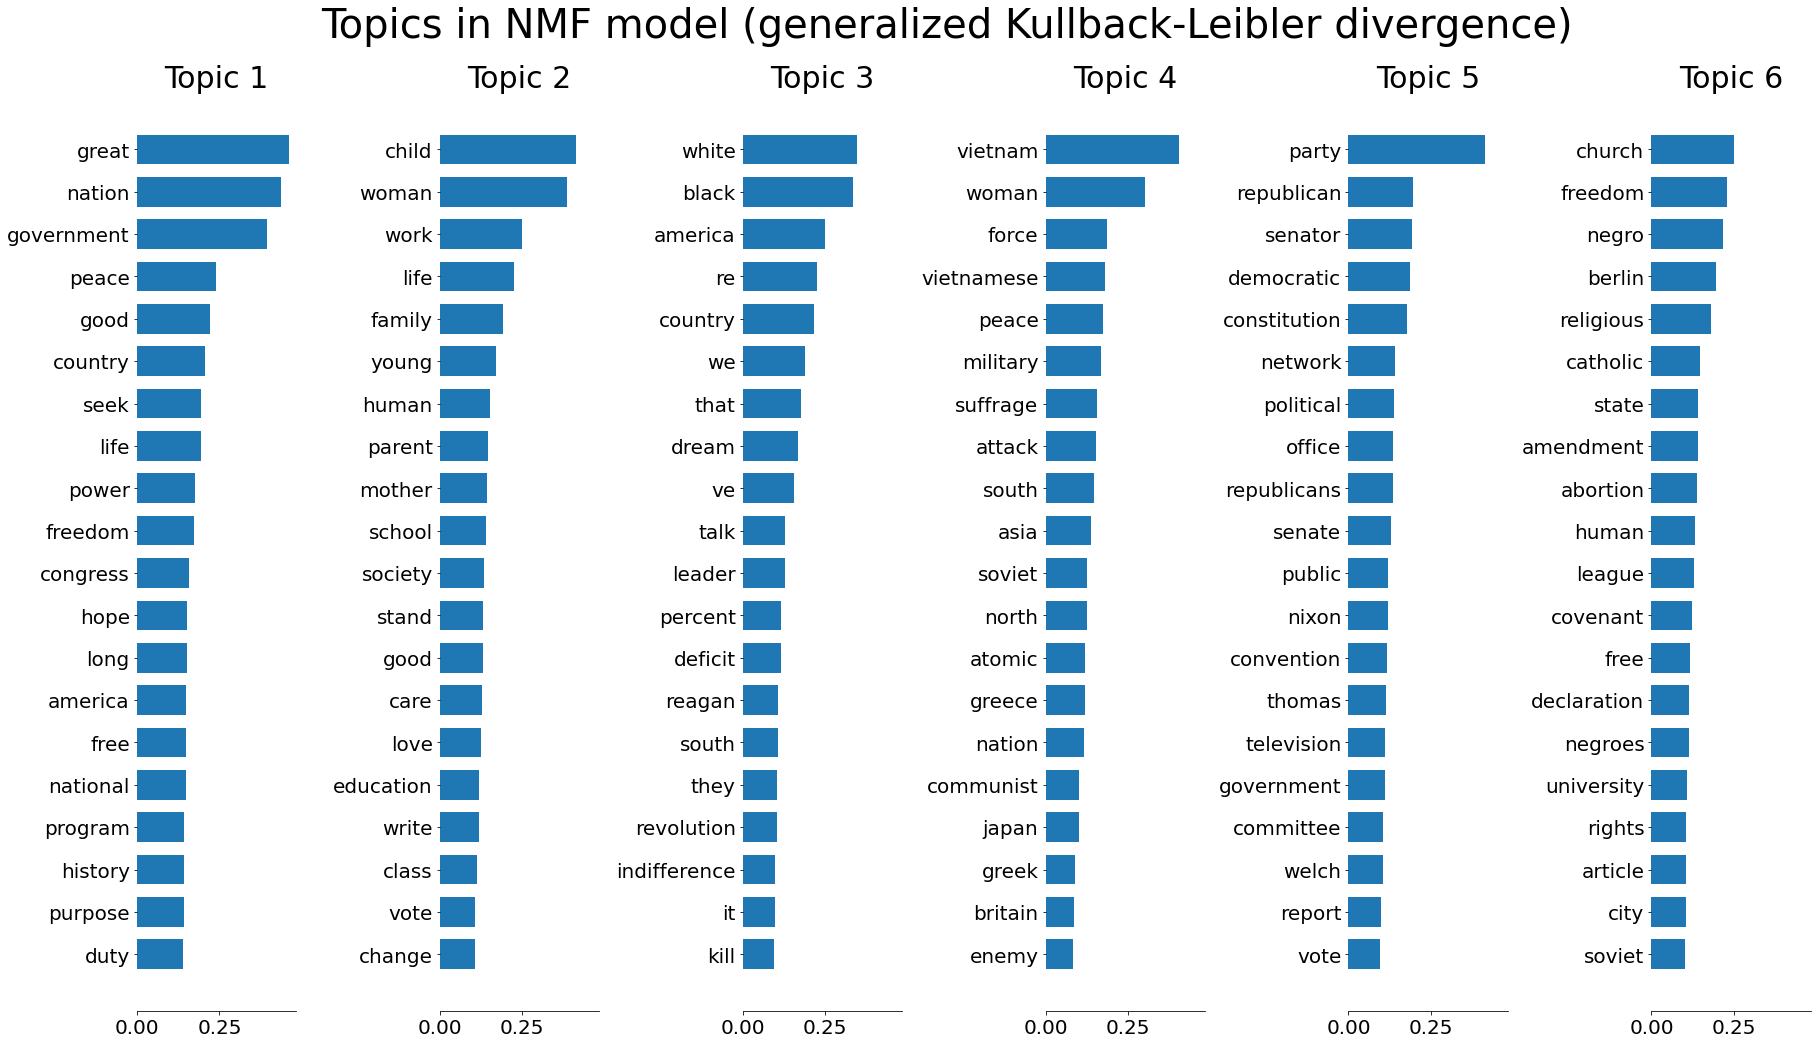

In [7]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5).fit(tfidf)


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

## Topic distribution
According to the representative words, we can summarise the topic as follow:

<span class="mark">1. American value/ Universal Value/ American Government\
2. Family/ Education/ Love/ Women\
3. Race\
4. War/ diplomatic\
5. Party/ constitution\
6. Religion</span>

## Frequency table

NMF using Kullback-leibler

In [8]:
w=nmf.fit_transform(tfidf)
topic_doc=np.argmax(w, axis=1)
topic_doc
unique, counts = np.unique(topic_doc, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0 22]
 [ 1 19]
 [ 2 13]
 [ 3 12]
 [ 4 17]
 [ 5 17]]


### Topic label 
Add a column, to represent the topic of the document

In [9]:
# add a column model label
text_data['NMF_topic'] = [(w+1) for w in topic_doc]
text_data[:10]

,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then,NMF_topic
0,I Have A Dream,"Martin Luther King, Jr.",1963,I am happy to join with you today in what will...,happy join history great demonstration freedom...,American minister,male,Null,34,6
1,Inaugural Address,John Fitzgerald Kennedy,1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",vice johnson speaker chief justice eisenhower ...,35th U.S. President,male,Null,44,1
2,First Inaugural Address-Franklin Delano Roosevelt,Franklin Delano Roosevelt,1933,"President Hoover, Mr. Chief Justice, my friend...",hoover chief justice friend national consecrat...,32nd U.S. President,male,Democratic,51,1
3,Pearl Harbor Address to the Nation,Franklin Delano Roosevelt,1941,"Mr. Vice President, Mr. Speaker, Members of th...",vice speaker members senate house representati...,32nd U.S. President,male,Democratic,59,4
4,1976 DNC Keynote Address,Barbara Charline Jordan,1976,Thank you ladies and gentlemen for a very warm...,lady gentleman warm reception fortyfour member...,Former United States Representative,female,Null,40,5
5,"""My Side of the Story"" (""Checkers"")",Richard Milhous Nixon,1952,"My Fellow Americans, I come before you tonight...",fellow candidate vice presidency honesty integ...,37th U.S. President,male,Republican,39,5
6,The Ballot or the Bullet,Malcolm X,1964,"Mr. Moderator, Rev. Cleage, brothers and siste...",moderator cleage brother sister friend enemy f...,American minister,male,Republican,39,3
7,Shuttle 'Challenger' Disaster Address,Ronald Wilson Reagan,1986,"Ladies and Gentlemen, Id planned to speak to y...",ladies gentlemen plan speak report state union...,40th U.S. President,male,Republican,75,2
8,Houston Ministerial Association,John Fitzgerald Kennedy,1960,"Reverend Meza, Reverend Reck, Im grateful for ...",reverend meza reverend reck grateful generous ...,35th U.S. President,male,Null,43,6
9,We Shall Overcome,Lyndon Baines Johnson,1965,"Mr. Speaker, Mr. President, Members of the Con...",speaker members congress speak dignity destiny...,36th U.S. President,male,Democratic,57,6


In [10]:
text_data[text_data["NMF_topic"]==3][:10]

,Title,Lecturer,Year,Doc,clean,profession,gender,party,age_then,NMF_topic
6,The Ballot or the Bullet,Malcolm X,1964,"Mr. Moderator, Rev. Cleage, brothers and siste...",moderator cleage brother sister friend enemy f...,American minister,male,Republican,39,3
11,1984 DNC Address,Jesse Louis Jackson,1984,Tonight we come together bound by our faith in...,bind faith mighty genuine respect love country...,"Former Shadow US Senator, DC",male,Null,43,3
14,I've Been to the Mountaintop,"Martin Luther King, Jr.",1968,"Thank you very kindly, my friends. As I listen...",kindly friend listen ralph abernathy eloquent ...,American minister,male,Null,39,3
16,Remarks on the Assassination of MLK,Robert Francis Kennedy,1968,"Ladies and Gentlemen, Im only going to talk to...",ladies gentlemen talk minute evening news sign...,Former United States Attorney General,male,Democratic,43,3
37,1988 DNC Keynote Address,Dorothy Ann Willis Richards,1988,"Thank you, very much. Good evening, ladies and...",good evening lady gentleman buenas noches ami...,Former Governor of Texas,female,Null,55,3
48,1988 DNC Address,Jesse Louis Jackson,1988,"Tonight, we pause and give praise and honor to...",pause praise honor good place convention face ...,"Former Shadow US Senator, DC",male,Null,47,3
62,Black Power,Stokely Carmichael,1966,Thank you very much. Its a privilege and an h...,its privilege honor white intellectual ghett...,Political activist,male,Democratic,25,3
70,Farewell to Baseball Address,Henry Louis (Lou) Gehrig,1939,"Fans, for the past two weeks you have been rea...",fans week read break lucky face earth ballpark...,Baseball first baseman,male,Null,36,3
78,1992 DNC Address,Elizabeth Glaser,1992,"Im Elizabeth Glaser. Eleven years ago, while g...",elizabeth glaser birth child hemorrhage transf...,American child actor,male,Null,45,3
81,Left-Handed Commencement Address,Ursula Kroeber Le Guin,1983,I want to thank the Mills College Class of fo...,mills college class offer rare chance speak al...,American author,female,Null,54,3


## Test

### Draw keywords from each topic

In [12]:
keywords_topic = []
for j in range(n_components):
    keywords_topic.append(keywords.keywords(" ".join([i for i in text_data['clean'][(topic_doc==j).tolist()]]),words=50).split('\n'))

In [13]:
for j in range(n_components):
    print("topic",j+1,":",keywords_topic[j],"\n")

topic 1 : ['nation', 'nations', 'national', 'nationally', 'nationalization', 'nationality', 'government', 'govern', 'governed', 'great', 'greatly', 'greatness', 'peace', 'peaceful', 'peacefully', 'life', 'good', 'goodness', 'goodly', 'country', 'freedom', 'power', 'powerful', 'powerfully', 'work', 'working', 'seek', 'long', 'longing', 'public', 'publicly', 'labor', 'laborer', 'americas', 'america', 'political', 'politic', 'politics', 'politically', 'human', 'humanity', 'humane', 'humanize', 'industrial', 'industry', 'force', 'problem', 'hope', 'free', 'economic', 'economical', 'economically', 'economics', 'bank', 'banks', 'effort', 'history', 'program', 'programs', 'republican', 'republicans', 'republicanism', 'purpose', 'secure', 'securely', 'security', 'stand', 'standing', 'face', 'faced', 'individual', 'individualism', 'individually', 'banking business', 'word place friend', 'friendly', 'congress', 'energy faith', 'strength', 'action', 'land', 'landing', 'lands', 'state', 'stately',

### Word cloud of every topic

In [14]:
add_stop_words = ['like','youre','ive','im','really','id','ve','just','dont','didnt','thi','wa',
                  'say','know','make','people',"today","way","day","time","year",'tonight']

boring_words = ['say','like','just','dont','don','im',
                'live','youll','youve','things','thing','youre','right','really','lot',
                'make','know','people','way','day',
                'little', 'maybe','men',"americans","america"
                'kind','heart', "american","president","united","states"         
                ]

gist_file = open(r"C:\Users\1\Desktop\研一下\MDA\project\gist_stopwords.txt", "r")
content = gist_file.read()
stop_words = content.split(",")+boring_words+add_stop_words

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\1\\Desktop\\研一下\\MDA\\project\\gist_stopwords.txt'

In [ ]:
topic=["Topic "+str(i+1) for i in range(6)]
topic

In [ ]:
wordlist_topic=[]
for i in range(6):
    df=text_data.loc[text_data["NMF_topic"]==i+1]
    df_topic=df["clean"].tolist()
    wordlist_topic.append(" ".join(df_topic))

data={"Topic":topic,"Wordcloud":wordlist_topic}
df_wordcloud=pd.DataFrame(data)
df_wordcloud

In [26]:
%run C:\Users\1\Desktop\研一下\MDA\project\word_cloud

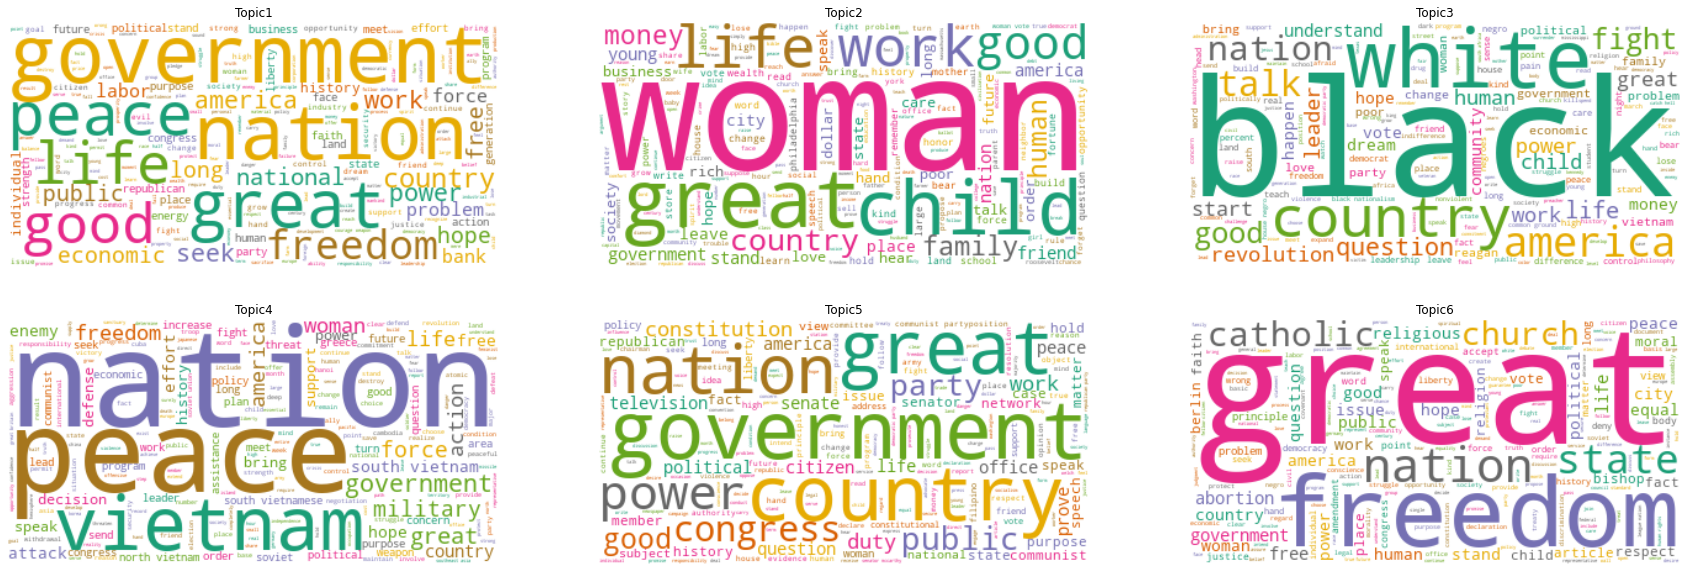

In [27]:
show_word_cloud(df_wordcloud,"Wordcloud",stop_words,collocation_threshold = 30)

### The distribution of time in each topic

In [11]:
for j in range(n_components):
    print("Topic",j+1,":",text_data['Year'][np.where(topic_doc==j)[0]].tolist(),"\n")

Topic 1 : [1961, 1933, 1906, 1961, 1917, 1962, 1964, 1981, 1933, 1963, 1974, 1941, 1947, 1984, 1937, 1964, 1980, 1932, 1913, 1979, 1963, 1966] 

Topic 2 : [1986, 1984, 1924, 1900, 1934, 1915, 1950, 1918, 1995, 1990, 1992, 1964, 1984, 1916, 1968, 1920, 1925, 1935, 1995] 

Topic 3 : [1964, 1984, 1968, 1968, 1988, 1988, 1966, 1939, 1992, 1983, 1963, 1999, 1971] 

Topic 4 : [1941, 1951, 1969, 1940, 1947, 1953, 1967, 1962, 1970, 1917, 1968, 1920] 

Topic 5 : [1976, 1952, 1974, 1950, 1900, 1969, 1952, 1917, 1969, 1948, 1917, 1961, 1991, 1974, 1952, 1974, 1954] 

Topic 6 : [1963, 1960, 1965, 1963, 1983, 1918, 1963, 1983, 1948, 1984, 1919, 1964, 1968, 1970, 1987, 1919, 1948] 



In [12]:
text_data['Topic']=[int(i)+1 for i in topic_doc.tolist()] # add a new column

In [13]:
text_data.to_csv("speech_100_topic.csv",index=False) # save the table

### Topic Analysis

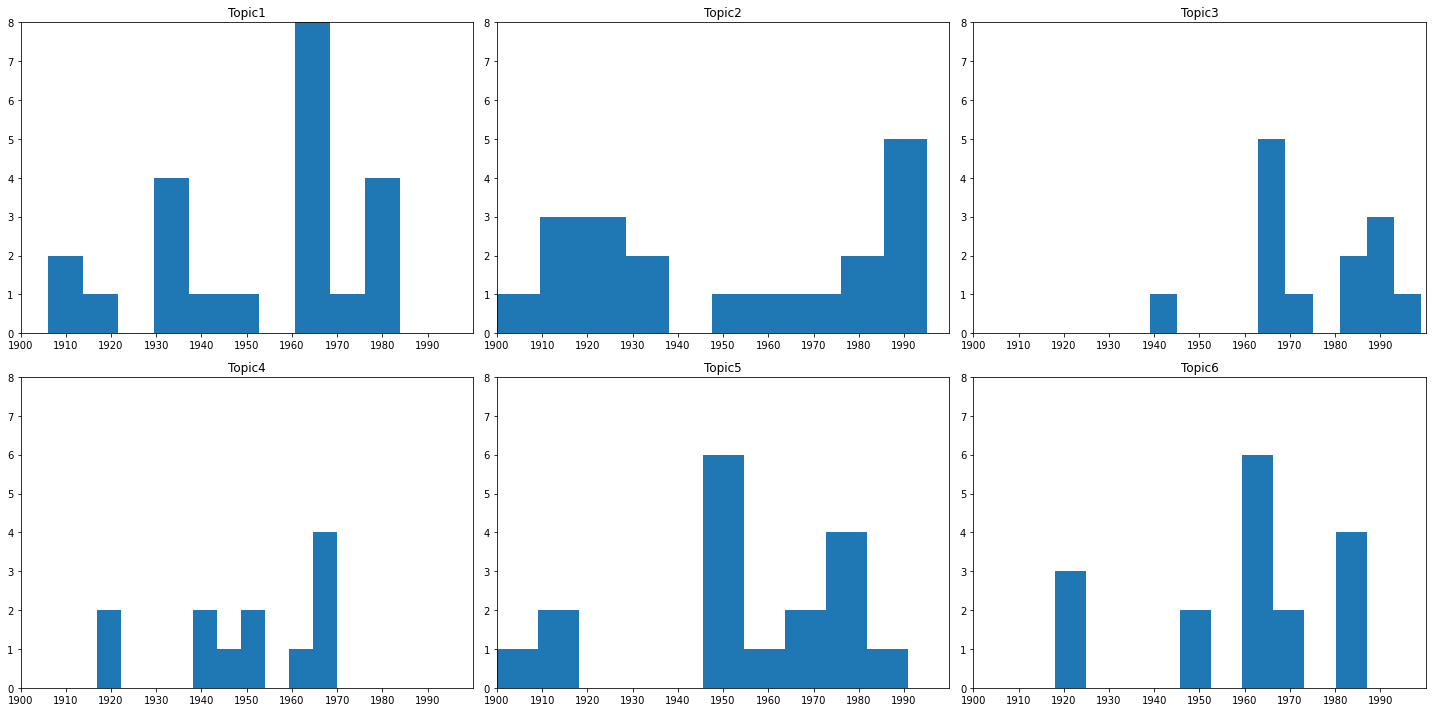

In [17]:
plt.rcParams['figure.figsize'] = [20, 10]

for j in range(n_components):
    ax=plt.subplot(2,3,j+1)
    ax.hist(text_data['Year'][np.where(topic_doc==j)[0]].tolist(),bins=10)
    ax.set_xticks(np.arange(1900,2000,10))
    ax.set_xlim(1900,2000)
    ax.set_ylim(0,8)
    plt.title("Topic"+str(j+1))
    
plt.tight_layout()
plt.show()

## 1. model selection

### LDA topic model
The meaning of the words is not representative. The topics share the same set of high-frequency words, and the words of topics overlap a lot. This is because most of the speeches are made by American politicians, and the topics are very similar. NMF is capable of identifying subtle topics that tend to be under-reported in traditional LDA approaches. When the corpus is small, the NMF performs much better than LDA. 

The figure generated by the NMP shows that the overlapping of words on different topics is reduced. The topics have specific meanings. However, the numbers of documents assigned to each topic differ significantly. Topic 1 includes most of the documents. The other topics share a small part of the speeches, making further analysis much harder. 

The words from each topic are representative and interpretable. The numbers of documents assigned to topics are pretty similar. So we adopt this method to allocate topics to each document. We calculate the probability distribution of topics for each document and then assign the topic with the highest probability to the document. As seen from the table, we can interpret the topics as follows: 

<span class="mark">1. American value/ Universal Value/ American Government\
2. Family/ Education/ Love/ Women\
3. Race\
4. War/ diplomatic\
5. Party/ constitution\
6. Religion</span>

## 2. Topic Year
We find the time of the speeches on each topic. The time distribution of topics is presented in the barplot. We also calculate the mean topic probability distribution of documents every decade. How the topic distribution changes over time is shown in the pictures.

The documents belonging to the topic1 were published throughout the 20th century. As shown from the table, topic 1 is about the American value, Universal values, and American Government, these topics are the basis of American politics so they are focused all the time.

For topic 2, which is related to family, education, love, and women, the documents were most published throughout the century, especially in the late century. In the 1990s, after the cold war, the economy of America flourished so that the politicians and American people cared more about these topics.

The documents on topic 3 are mainly about equal rights, race, and Vietnam War. Most of the speeches on this topic were delivered in the 1960s and 1970s when the Vietnam War began and the Civil Rights Movement was growing.

The speeches of topic 4, which represent war, diplomacy, and Europe, were mainly made in the middle of the 20th century. We can find that the cold war, World War II, and the Cold War happened at that time, which drew the politicians' and the public's attention. 

Topic 5 is related to the party and constitution, which were published throughout the 20th century. Since this topic is always focused on by all politicians no matter when they are in power.

The speeches from topic 6 focused on religion and economy and were mainly delivered in the late 20th century when America had revived from Great Depression and the economy was stimulated. In the 1980s, President Ronald Reagan rejuvenated the conservative Republican ideology, which is the Rise of Conservatism.



In [37]:
year_10 = list(range(1900,2000,10))
year_topic=[]
for i in year_10:
    year_topic.append(w[(text_data['Year']<i+10) & (text_data['Year']>=i).tolist()].mean(axis=0).tolist())

In [55]:
year_topic = pd.DataFrame(year_topic).T

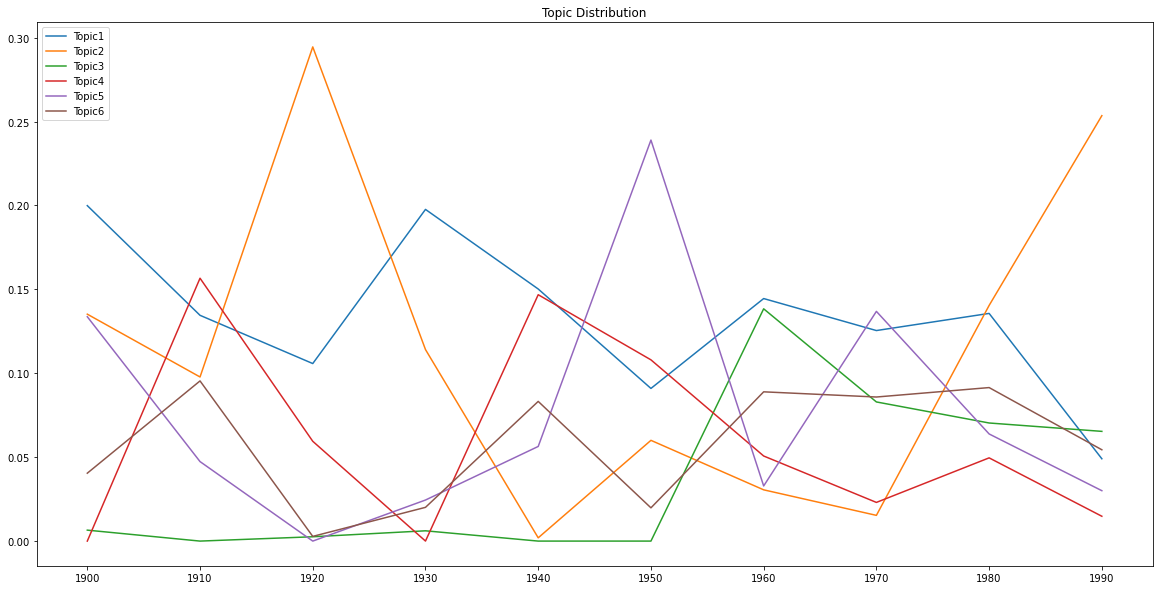

In [73]:
for i in range(6):
    plt.plot(year_10,year_topic[i],label="Topic"+str(i+1))
plt.xticks(np.arange(1900,2000,10))
plt.title("Topic Distribution")
plt.legend()

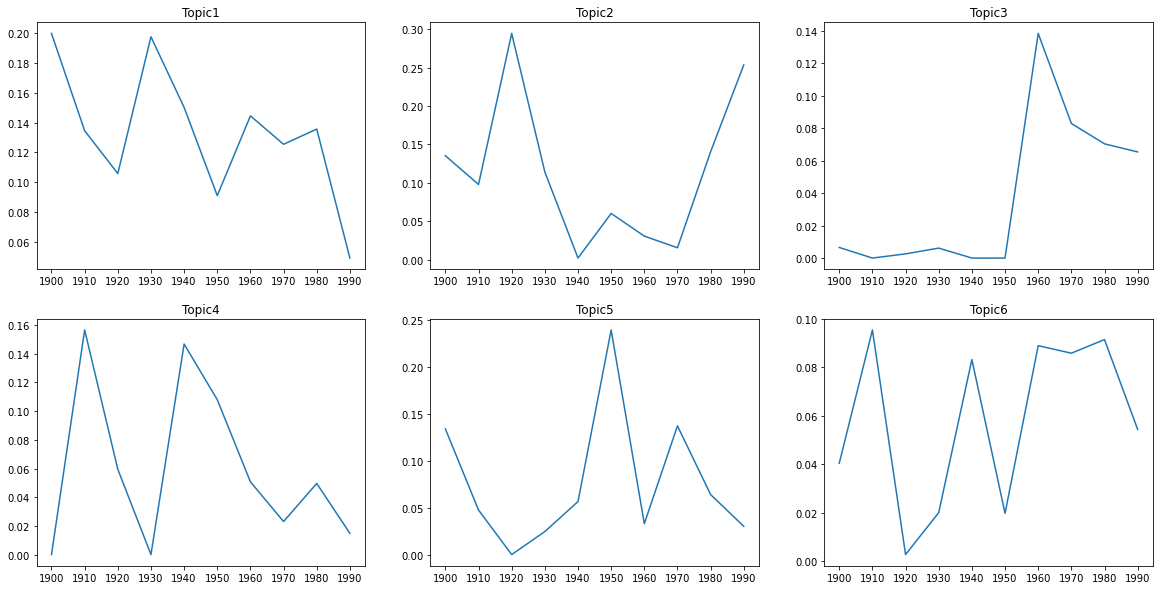

In [76]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(year_10,year_topic[i],label="Topic"+str(i+1))
    plt.xticks(np.arange(1900,2000,10))
    plt.title("Topic"+str(i+1))
    #plt.legend()
#plt.title("Topic Distribution")

## Topic Gender 
The gender and party distribution of each topic is shown separately. 

In general, most of the speeches are given by politicians and there’s 81 out of the 100 speeches are delivered by male speakers, which reflects the unequal participation and leadership in political and public life.

All the speeches on topic 1 (American government) are held by males which again demonstrates the under-representation of women in government positions. Also, there’s a relatively high percentage (approximately 85%) of speeches delivered by male speaker on topic 3, 4 and 6 as well, which are equal rights & race, war & diplomacy respectively and religions respectively. 

On the other hand, around 32% of the speeches on topic 2 (family, education, love and women) and 35% on topic 5 (party and constitution) are given by females. This result is consistent with the fact that family & children care, women affairs & gender equality are the most commonly held portfolios by women ministers and politicians and shows that women have higher interest in the topics relating to constitution and political parties.

## Topic Party

We focus only on the comparison between the two major contemporary political parties in the United States. there are in total 39 speeches delivered by the Democrats and 16 by the Republicans.  

Both of the two parties show great concern in the topic 1 which is associated with American value, Universal values, and American Government, and they show equal interests in topic 5 (party and constitution) as well. This makes sense as topic 1 and 5 should be of main interest of politicians and presidents from either political party.

The Democrats dominate on the topic 2 relating to family, education, love and women and they have a relatively higher number of speeches on the religions and human rights (topic 6).

Most of the speeches on topics 3 and 4 are delivered by speakers with no specific political position, especially on topic 3 which is mainly related to racial equality. This could partly due to the fact that the majority of the US politicians have been white for centuries and black people have been in a relatively inferior position until very recent years.

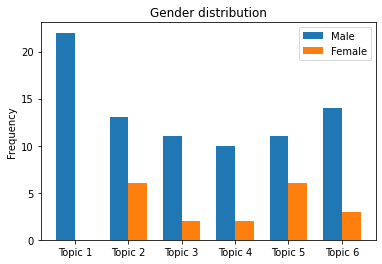

In [12]:
topics=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']
males=[]
for j in range(n_components):
    males.append(text_data['gender'][np.where(topic_doc==j)[0]].tolist().count('male'))
females=[]
for j in range(n_components):
    females.append(text_data['gender'][np.where(topic_doc==j)[0]].tolist().count('female'))

x = np.arange(len(topics))  
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, males, width, label='Male')
rects2 = ax.bar(x + width/2, females, width, label='Female')

ax.set_ylabel('Frequency')
ax.set_title('Gender distribution')
ax.set_xticks(x)
ax.set_xticklabels(topics)
ax.legend()

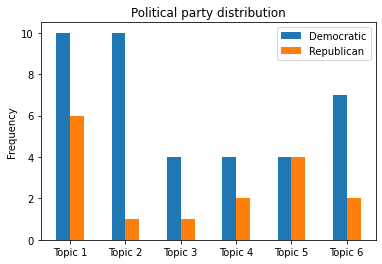

In [13]:
topics=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']
democratic=[]
for j in range(n_components):
    democratic.append(text_data['party'][np.where(topic_doc==j)[0]].tolist().count('Democratic'))
republican=[]
for j in range(n_components):
    republican.append(text_data['party'][np.where(topic_doc==j)[0]].tolist().count('Republican'))
#null=[]
#for j in range(n_components):
    #null.append(text_data['party'][np.where(topic_doc==j)[0]].tolist().count('Null'))

x = np.arange(len(topics))  
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, democratic, width, label='Democratic')
rects2 = ax.bar(x + width/2, republican, width, label='Republican')
#rects3 = ax.bar(x + width*1.5, null, width, label='Null')

ax.set_ylabel('Frequency')
ax.set_title('Political party distribution')
ax.set_xticks(x)
ax.set_xticklabels(topics)
ax.legend()

### frequency plot of different parties

<AxesSubplot:title={'center':'Frequency of Words Democratic'}>

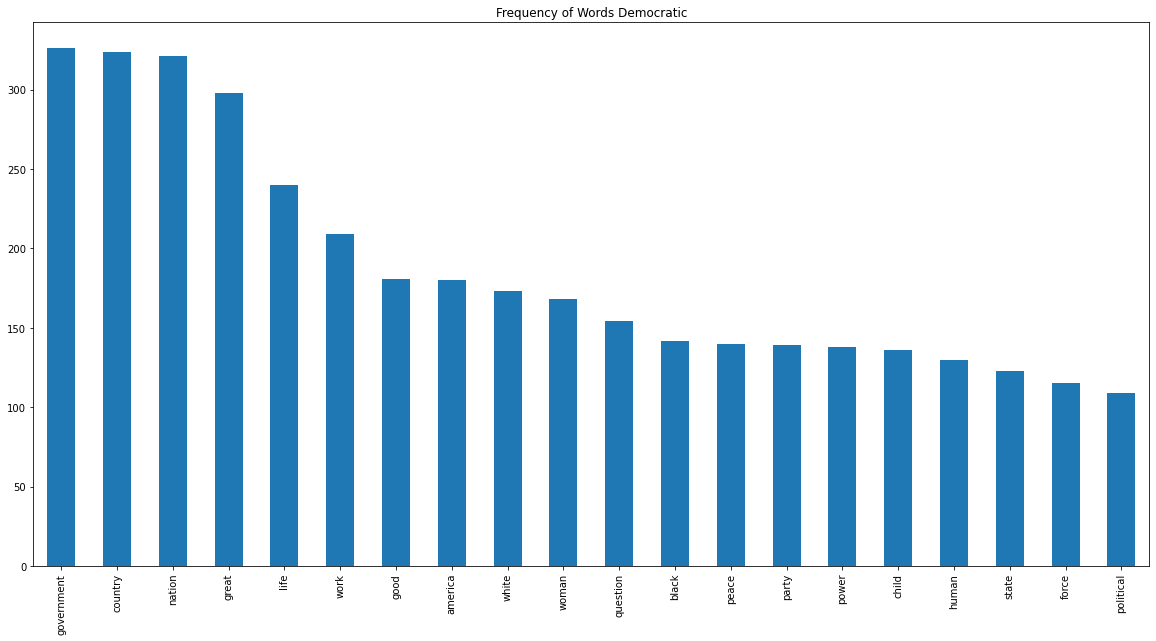

In [25]:
Democratic=text_data.query('party == "Democratic"')
freq= pd.Series((' '.join(Democratic['clean']).split())).value_counts().sort_values(ascending = False)
freq1=freq[0:20]
freq1.plot(kind='bar',title="Frequency of Words Democratic")

<AxesSubplot:title={'center':'Frequency of Words Republican'}>

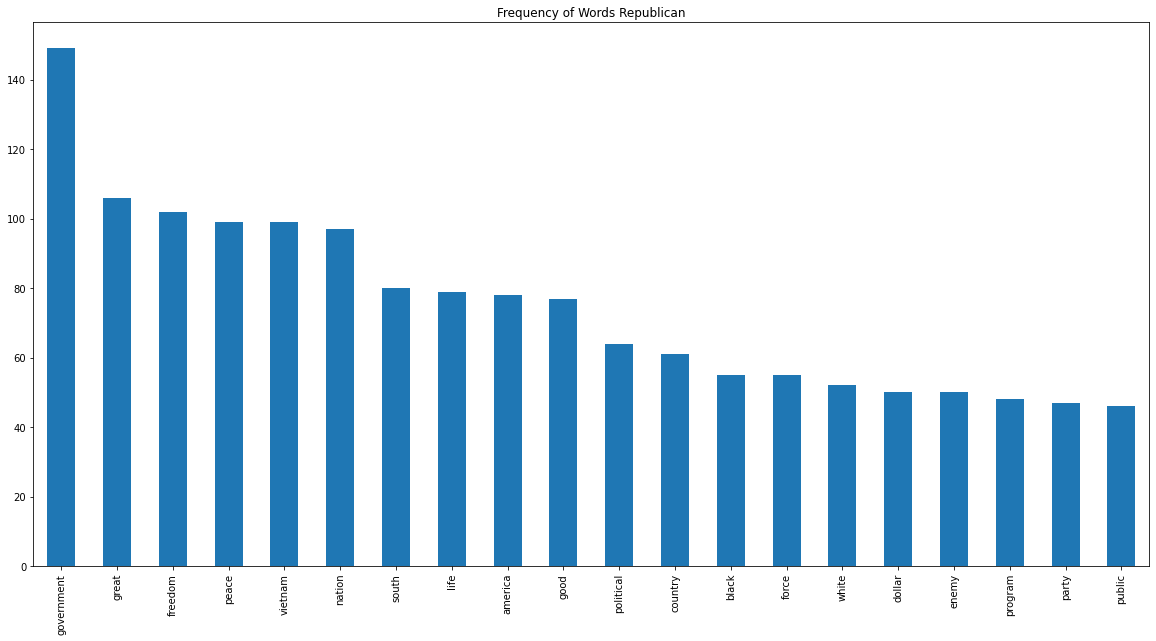

In [19]:
Republican=text_data.query('party == "Republican"')
freq= pd.Series((' '.join(Republican['clean']).split())).value_counts().sort_values(ascending = False)
freq1=freq[0:20]
freq1.plot(kind='bar',title="Frequency of Words Republican")

From the frequency plot, we found that there are differences on words uses between the two parties. The democratic pay more attention on the woman and family topic, while the republicans  focus on the economic growth, war and construction. The democratic emphasize on the government and the country while the republicans think that the individual freedom is more important, that's how they different in the values.